## ZYX

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




## Raw data

In [5]:
ad = readRDS("/home/ubuntu/project/snatac_case_study/RSS_QC_RAISS_imputed.chr7_143353277_145271128.univariate_susie_rss.rds")

## Data loading

In [279]:
#effect_table_snatac =  read_delim("/data/analysis_result/snatac_fsusie/top_loci/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz") # This is what should be loaded while at the moment I loaded the copy in my local folder first. 
effect_table_snatac =  read_delim("/data/interactive_analysis/hs3163/output_file/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz") 

Rows: 554 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): #chr, a1, a2, variant_ID, event_ID, region_ID, cs_id, cs_root, epi...
dbl  (8): start, end, TADB_start, TADB_end, maf, PIP, cs_coverage_0.95, grid...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
effect_table_snatac_zyx = effect_table_snatac%>%filter(region_ID == "chr7_139293693_145380632")

In [12]:
effect_table_snatac_zyx$cs_id


[1] "ROSMAP_snATAC_Kelis_Mic:chr7_139293693_145380632:29"

In [17]:

library(data.table)
library(dplyr)
library(magrittr)
library(ggplot2)
library(ggrepel)
library(cowplot)
library(tidyverse)
source("/data/interactive_analysis/hs3163/snatac_case_study/fsusie-experiments/scripts_plot/cases_study/get_gene_annotations.R")
source("/data/interactive_analysis/hs3163/snatac_case_study/fsusie-experiments/scripts_plot/cases_study/interpolate_effect_estimates.R")
gene_file <-
  file.path("/home/ubuntu/data/resource/references/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf")
genes <- get_gene_annotations(gene_file)


eQTL_1 = readRDS("~/data/analysis_result/finemapping_twas/susie_twas/ROSMAP_DeJager_eQTL.ENSG00000159840.univariate_susie_twas_weights.rds")
GWAS_1 = readRDS("/data/interactive_analysis/hs3163/snatac_case_study/RSS_QC_RAISS_imputed.chr7_143353277_145271128.univariate_susie_rss.rds")


key_marker = 143414203
pos0 = 143353277
pos1  = 143500000

In [18]:

# ─────────────────────────────────────────────
# SECTION 1: GWAS
# ─────────────────────────────────────────────
GWAS_1 = (GWAS_1[[1]][[2]])%>%select(variant_id,pos,beta,se,z,pval = pvalue )%>%
                                mutate(CS = variant_id %in%  
((GWAS_1[[1]][[1]][["top_loci"]])%>%filter(cs_coverage_0.95 != 0)%>%pull(variant_id))  )%>%
mutate(variant_id = paste0("chr",variant_id ))%>%mutate( id = ifelse(CS != 0, variant_id,NA))

# ─────────────────────────────────────────────
# SECTION 2: eQTL
# ─────────────────────────────────────────────
eQTL_pdat_1 = tibble(
variant_id = eQTL_1[[1]][["Mic_DeJager_eQTL"]][["variant_names"]],
beta = eQTL_1[[1]][["Mic_DeJager_eQTL"]][["sumstats"]][[1]],
se = eQTL_1[[1]][["Mic_DeJager_eQTL"]][["sumstats"]][[2]])%>%mutate(z  = beta/se, CS = variant_id %in% 
                                                                   ((eQTL_1[[1]][["Mic_DeJager_eQTL"]][["top_loci"]])%>%filter(cs_coverage_0.95 == 1 )%>%pull(variant_id)) 
                                                                   )%>%separate(variant_id,into = c("chr","pos"),remove = F)%>%mutate(pos = as.numeric(pos), id = ifelse(CS != 0, variant_id,NA) )%>%mutate(pval = 2 * pnorm(-abs(z)))



Warning message:
“Expected 2 pieces. Additional pieces discarded in 15803 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [19]:


# ─────────────────────────────────────────────
# SECTION 4: PANEL 3 – mSNP PIP fine-mZYXing
# ─────────────────────────────────────────────
# ─────────────────────────────────────────────
# SECTION 4: PANEL 3 – mSNP PIP fine-mapping
# ─────────────────────────────────────────────
pdat3 <- data.frame(
  id  = effect_table_snatac_zyx$variant_ID,
  pos = effect_table_snatac_zyx$end,
  pip = effect_table_snatac_zyx$PIP,
  cs  = effect_table_snatac_zyx$cs_coverage_0.95,
  stringsAsFactors=FALSE
)
rownames(pdat3) = pdat3$id

pdat4 <- effect_table_snatac_zyx%>%select(pos	= epi_mark_positions,effect = epi_mark_effects)%>%
separate_rows(pos,effect,sep = ";")%>%mutate_all(as.numeric)

pdat5 <- genes %>%
  filter(chromosome=="chr7", end>pos0, start<pos1) %>%
  mutate(
    start = start,
    end   = end,
    tss   = ifelse(strand=="+", start, end),
    y     = seq(0,1,length.out=n())
  )

In [21]:
p1 <- ggplot(GWAS_1, aes(x = pos, y = -log10(as.numeric(pval))*sign(z), col=CS,label = id)) +
  geom_point(size=1) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=5, color="dimgray", segment.color="dimgray",
                  min.segment.length=0, max.overlaps=Inf) +
  scale_color_manual(values=c("black","dodgerblue")) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="signed -log10(pval) for AD") + theme_cowplot(font_size = 9) 

In [22]:
p2 <- ggplot(eQTL_pdat_1, aes(x = pos, y = -log10(as.numeric(pval))*sign(z), col=CS,label = id)) +
  geom_point(size=1) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=5, color="dimgray", segment.color="dimgray",
                  min.segment.length=0, max.overlaps=Inf) +
  scale_color_manual(values=c("black","dodgerblue")) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="signed -log10(pval) for eQTL") + theme_cowplot(font_size = 9) 

In [23]:
p3 <- ggplot(pdat3, aes(pos, pip,  label=id)) +
  geom_point(size=0.75) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=10, color="dimgray", segment.color="dimgray",
                  min.segment.length=0, max.overlaps=Inf) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="ca-SNP PIP") +
  theme_cowplot(font_size=9)


In [28]:
# ─────────────────────────────────────────────
# SECTION 5: PANEL 4 – SNATAC effect estimates
# ─────────────────────────────────────────────


p4 =  ggplot() +
  geom_hline(yintercept=0, linetype="dotted") +
  geom_point(data=subset(pdat4),
             aes(x=pos,y=effect), color="black", size=1) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  labs(x="", y="effect of A allele") +
  scale_x_continuous(limits=c(pos0,pos1))  +ylim(0.02,0.09)+
  theme_cowplot(font_size=9)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”
Warning message:
“Removed 152 rows containing missing values or values outside the scale range
(`geom_point()`).”


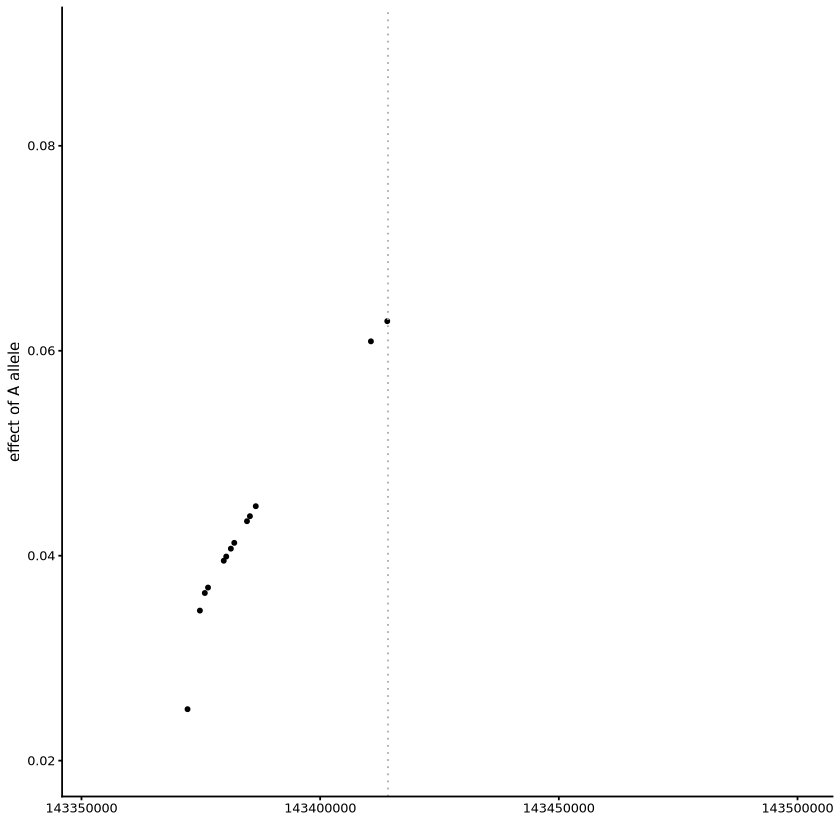

In [29]:
p4

In [38]:


p5 <- ggplot(pdat5, aes(x=start, xend=end, y=y, yend=y, label=gene_name)) +
  geom_segment(color="dodgerblue", size=0.5) +
  geom_point(aes(x=tss), color="dodgerblue", shape=18, size=1.5) +
  geom_text(color="black", size=5, fontface="italic",
            hjust="right", nudge_x=-0.003) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  #scale_x_continuous(limits=c(pos0,pos1)/1e6, breaks=seq(45,48,0.05)) +
  scale_x_continuous(limits=c(pos0,pos1))+  labs(x="base-pair position on chromosome 7", y="") +
  theme_cowplot(font_size=9)

In [39]:
pdat5

chromosome,source,feature,start,end,strand,ensembl,gene_type,gene_name,tss,y
<fct>,<fct>,<fct>,<int>,<int>,<fct>,<chr>,<fct>,<chr>,<int>,<dbl>
chr7,ensembl_havana,transcript,143353400,143362725,-,ENSG00000159784,protein_coding,FAM131B,143362725,0.00
chr7,ensembl_havana,transcript,143381295,143391111,+,ENSG00000159840,protein_coding,ZYX,143381295,0.25
chr7,ensembl_havana,transcript,143390289,143408856,-,ENSG00000146904,protein_coding,EPHA1,143408856,0.50
chr7,ensembl_havana,transcript,143443453,143444409,+,ENSG00000185899,protein_coding,TAS2R60,143443453,0.75
chr7,ensembl_havana,transcript,143477873,143478796,+,ENSG00000221855,protein_coding,TAS2R41,143477873,1.00


In [31]:
options(repr.plot.width = 10, repr.plot.height = 10)

In [40]:
fig <- plot_grid(p1+theme(text = element_text(size =10 )), 
                 p2+theme(text = element_text(size =10 )),
                 p3+theme(text = element_text(size =20 )),
                 p4+theme(text = element_text(size =20 )),
                 p5+theme(text = element_text(size =20 ))
                 #p6+theme(text = element_text(size =10 ))
                 #,p7+theme(text = element_text(size =10 ))
                 , nrow=5
                 , align="v")


Warning message:
“Removed 5570 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 6143 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 15228 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 15800 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”
Warning message:
“Removed 152 rows containing missing values or values outside the scale range
(`geom_point()`).”


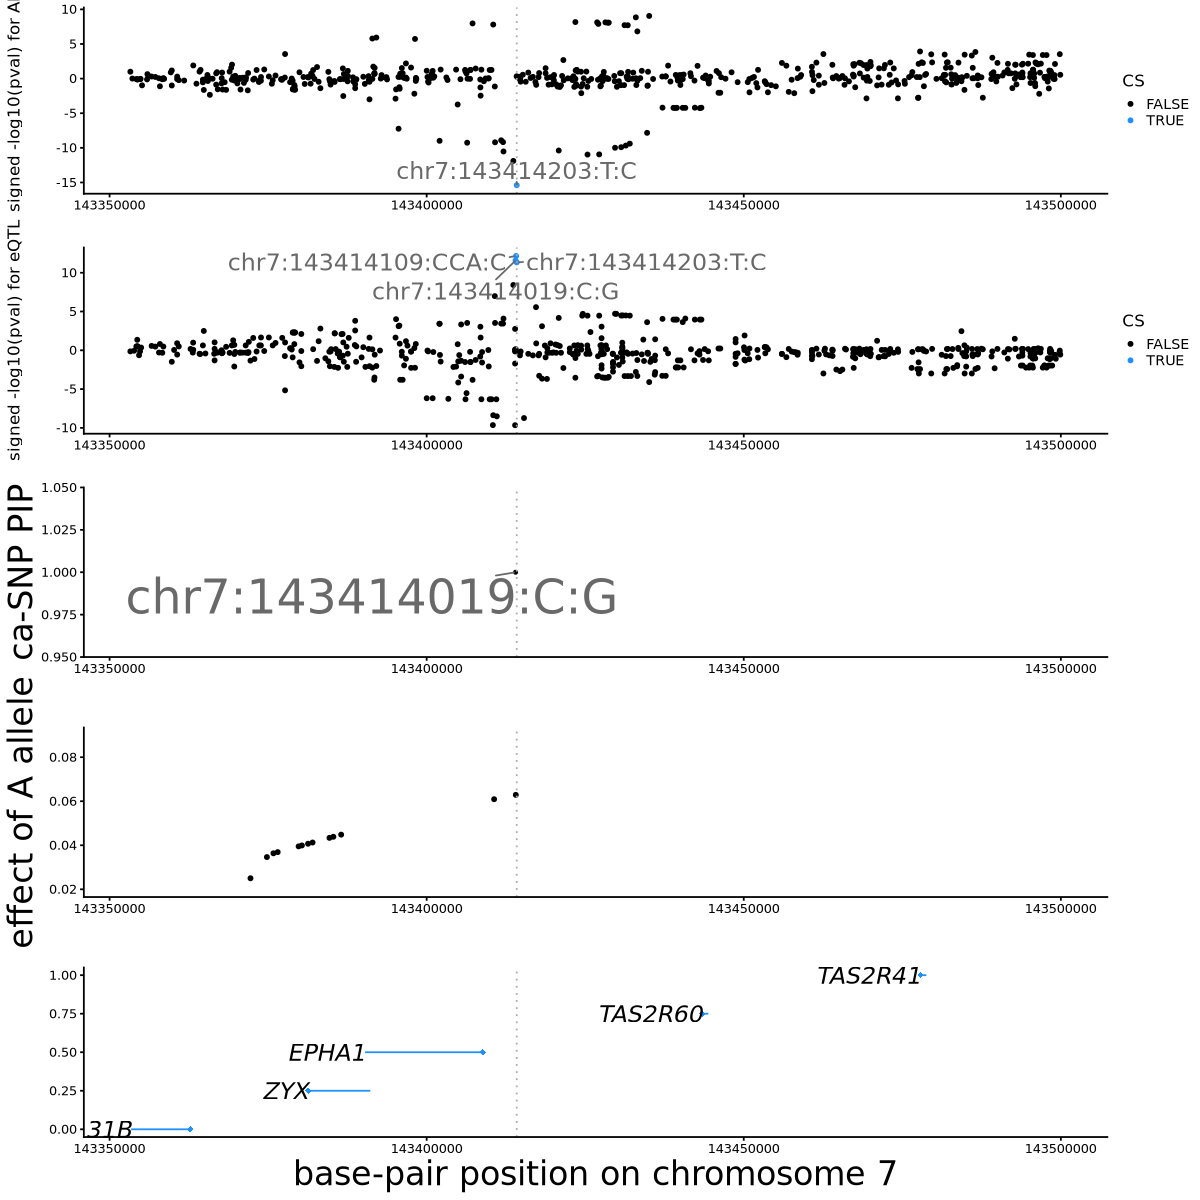

In [41]:
fig

